# setup

## environments

In [1]:
# importing libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# for reproducibility

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# using GPU (colab T4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [4]:
# for data setup (no perturbations)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## modules

In [5]:
# dataset loader function

def get_dataloaders(transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
    return trainset, trainloader, testloader

In [6]:
# model architectures: simple & deeper

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # returns the final prediction logits

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1, stride=2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1, stride=2), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, stride=2), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
# training

def train_model(model, trainloader, epochs):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}: Loss = {running_loss / len(trainloader):.4f}")

In [8]:
# evaluation

def evaluate_model(model, testloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\nOverall Test Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# experimentation

## baseline testing

In [9]:
# CIFAR-10 정답 라벨 그대로 학습

### SimpleCNN

In [10]:
trainset, trainloader, testloader = get_dataloaders(transform)
classes = trainset.classes  # global assignment (once)
model = SimpleCNN()
train_model(model, trainloader, epochs=50)

100%|██████████| 170M/170M [00:10<00:00, 16.6MB/s]


Epoch 1: Loss = 1.3083


Epoch 2: Loss = 0.9259


Epoch 3: Loss = 0.7588


Epoch 4: Loss = 0.6233


Epoch 5: Loss = 0.4949


Epoch 6: Loss = 0.3849


Epoch 7: Loss = 0.2797


Epoch 8: Loss = 0.1985


Epoch 9: Loss = 0.1405


Epoch 10: Loss = 0.1098


Epoch 11: Loss = 0.0847


Epoch 12: Loss = 0.0824


Epoch 13: Loss = 0.0723


Epoch 14: Loss = 0.0595


Epoch 15: Loss = 0.0520


Epoch 16: Loss = 0.0593


Epoch 17: Loss = 0.0483


Epoch 18: Loss = 0.0495


Epoch 19: Loss = 0.0483


Epoch 20: Loss = 0.0447


Epoch 21: Loss = 0.0435


Epoch 22: Loss = 0.0410


Epoch 23: Loss = 0.0383


Epoch 24: Loss = 0.0455


Epoch 25: Loss = 0.0374


Epoch 26: Loss = 0.0392


Epoch 27: Loss = 0.0374


Epoch 28: Loss = 0.0323


Epoch 29: Loss = 0.0427


Epoch 30: Loss = 0.0382


Epoch 31: Loss = 0.0405


Epoch 32: Loss = 0.0269


Epoch 33: Loss = 0.0322


Epoch 34: Loss = 0.0387


Epoch 35: Loss = 0.0355


Epoch 36: Loss = 0.0203


Epoch 37: Loss = 0.0329


Epoch 38: Loss = 0.0369


Epoch 39: Loss = 0.0283


Epoch 40: Loss = 0.0305


Epoch 41: Loss = 0.0257


Epoch 42: Loss = 0.0355


Epoch 43: Loss = 0.0234


Epoch 44: Loss = 0.0286


Epoch 45: Loss = 0.0237


Epoch 46: Loss = 0.0365


Epoch 47: Loss = 0.0257


Epoch 48: Loss = 0.0238


Epoch 49: Loss = 0.0291


Epoch 50: Loss = 0.0288



Overall Test Accuracy: 70.84%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.80      0.75      1000
  automobile       0.86      0.76      0.81      1000
        bird       0.61      0.61      0.61      1000
         cat       0.50      0.57      0.53      1000
        deer       0.70      0.62      0.66      1000
         dog       0.60      0.59      0.59      1000
        frog       0.84      0.73      0.78      1000
       horse       0.77      0.79      0.78      1000
        ship       0.86      0.78      0.82      1000
       truck       0.71      0.84      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



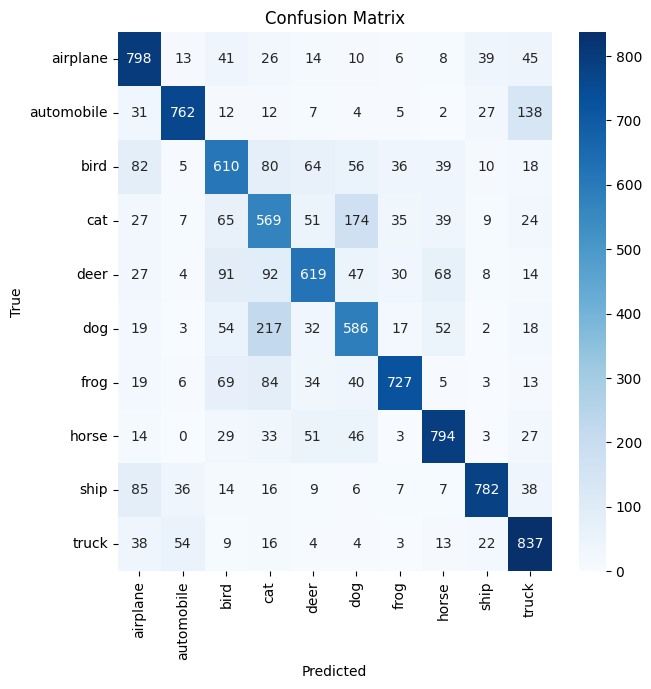

In [11]:
evaluate_model(model, testloader)

### DeeperCNN

In [12]:
trainset, trainloader, testloader = get_dataloaders(transform)
model = DeeperCNN()
train_model(model, trainloader, epochs=75)

Epoch 1: Loss = 1.3663


Epoch 2: Loss = 0.9594


Epoch 3: Loss = 0.7793


Epoch 4: Loss = 0.6522


Epoch 5: Loss = 0.5459


Epoch 6: Loss = 0.4549


Epoch 7: Loss = 0.3637


Epoch 8: Loss = 0.2982


Epoch 9: Loss = 0.2289


Epoch 10: Loss = 0.1948


Epoch 11: Loss = 0.1642


Epoch 12: Loss = 0.1348


Epoch 13: Loss = 0.1168


Epoch 14: Loss = 0.1049


Epoch 15: Loss = 0.0977


Epoch 16: Loss = 0.0856


Epoch 17: Loss = 0.0889


Epoch 18: Loss = 0.0745


Epoch 19: Loss = 0.0735


Epoch 20: Loss = 0.0708


Epoch 21: Loss = 0.0697


Epoch 22: Loss = 0.0594


Epoch 23: Loss = 0.0599


Epoch 24: Loss = 0.0562


Epoch 25: Loss = 0.0595


Epoch 26: Loss = 0.0532


Epoch 27: Loss = 0.0517


Epoch 28: Loss = 0.0502


Epoch 29: Loss = 0.0446


Epoch 30: Loss = 0.0490


Epoch 31: Loss = 0.0441


Epoch 32: Loss = 0.0449


Epoch 33: Loss = 0.0468


Epoch 34: Loss = 0.0482


Epoch 35: Loss = 0.0409


Epoch 36: Loss = 0.0368


Epoch 37: Loss = 0.0430


Epoch 38: Loss = 0.0379


Epoch 39: Loss = 0.0387


Epoch 40: Loss = 0.0338


Epoch 41: Loss = 0.0335


Epoch 42: Loss = 0.0357


Epoch 43: Loss = 0.0386


Epoch 44: Loss = 0.0351


Epoch 45: Loss = 0.0331


Epoch 46: Loss = 0.0311


Epoch 47: Loss = 0.0304


Epoch 48: Loss = 0.0334


Epoch 49: Loss = 0.0305


Epoch 50: Loss = 0.0320


Epoch 51: Loss = 0.0301


Epoch 52: Loss = 0.0287


Epoch 53: Loss = 0.0278


Epoch 54: Loss = 0.0268


Epoch 55: Loss = 0.0300


Epoch 56: Loss = 0.0318


Epoch 57: Loss = 0.0236


Epoch 58: Loss = 0.0309


Epoch 59: Loss = 0.0273


Epoch 60: Loss = 0.0253


Epoch 61: Loss = 0.0225


Epoch 62: Loss = 0.0267


Epoch 63: Loss = 0.0252


Epoch 64: Loss = 0.0239


Epoch 65: Loss = 0.0254


Epoch 66: Loss = 0.0221


Epoch 67: Loss = 0.0230


Epoch 68: Loss = 0.0234


Epoch 69: Loss = 0.0259


Epoch 70: Loss = 0.0231


Epoch 71: Loss = 0.0195


Epoch 72: Loss = 0.0254


Epoch 73: Loss = 0.0232


Epoch 74: Loss = 0.0235


Epoch 75: Loss = 0.0233



Overall Test Accuracy: 77.55%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.81      0.79      1000
  automobile       0.89      0.86      0.88      1000
        bird       0.67      0.68      0.67      1000
         cat       0.61      0.62      0.62      1000
        deer       0.77      0.72      0.74      1000
         dog       0.74      0.67      0.70      1000
        frog       0.77      0.86      0.81      1000
       horse       0.83      0.81      0.82      1000
        ship       0.88      0.86      0.87      1000
       truck       0.84      0.86      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



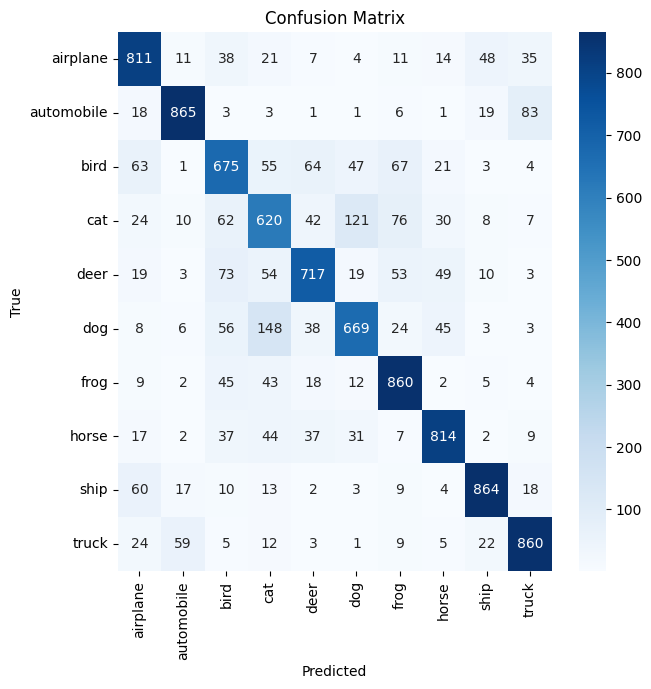

In [13]:
evaluate_model(model, testloader)

## random label shuffle

In [14]:
# 학습 데이터의 라벨을 완전히 무작위로 섞어서 학습

### SimpleCNN

In [15]:
# randomly shuffle the labels

trainset, trainloader, testloader = get_dataloaders(transform)
classes = trainset.classes  # global assignment (once)

shuffled_targets = torch.tensor(trainset.targets)
shuffled_targets = shuffled_targets[torch.randperm(len(shuffled_targets))]
trainset.targets = shuffled_targets.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [16]:
model = SimpleCNN()
train_model(model, trainloader, epochs=10)

Epoch 1: Loss = 2.3031


Epoch 2: Loss = 2.3028


Epoch 3: Loss = 2.3030


Epoch 4: Loss = 2.3028


Epoch 5: Loss = 2.3028


Epoch 6: Loss = 2.3028


Epoch 7: Loss = 2.3028


Epoch 8: Loss = 2.3028


Epoch 9: Loss = 2.3028


Epoch 10: Loss = 2.3027



Overall Test Accuracy: 9.98%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.11      0.01      0.02      1000
         cat       0.00      0.00      0.00      1000
        deer       0.10      0.98      0.18      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.02      0.10      0.02     10000
weighted avg       0.02      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


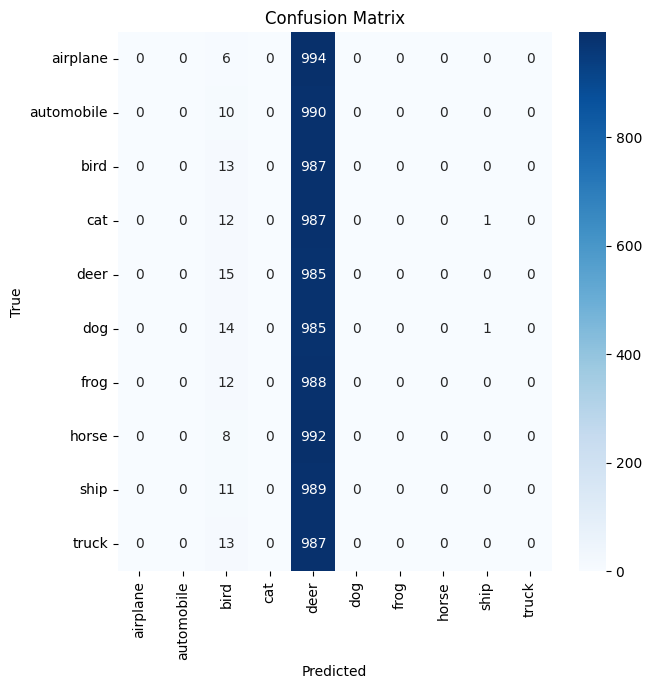

In [17]:
evaluate_model(model, testloader)

### DeeperCNN

In [18]:
# randomly shuffle the labels

trainset, trainloader, testloader = get_dataloaders(transform)  # reload fresh data

shuffled_targets = torch.tensor(trainset.targets)
shuffled_targets = shuffled_targets[torch.randperm(len(shuffled_targets))]
trainset.targets = shuffled_targets.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [19]:
model = DeeperCNN()
train_model(model, trainloader, epochs=10)

Epoch 1: Loss = 2.3097


Epoch 2: Loss = 2.3028


Epoch 3: Loss = 2.3027


Epoch 4: Loss = 2.3027


Epoch 5: Loss = 2.3027


Epoch 6: Loss = 2.3027


Epoch 7: Loss = 2.3027


Epoch 8: Loss = 2.3027


Epoch 9: Loss = 2.3027


Epoch 10: Loss = 2.3027



Overall Test Accuracy: 10.00%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.10      1.00      0.18      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


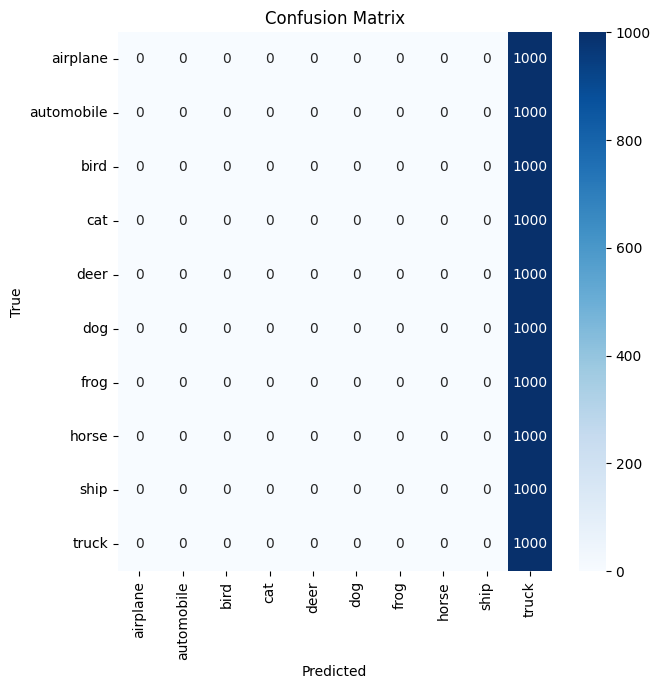

In [20]:
evaluate_model(model, testloader)

## label noise (20%)

In [21]:
# 학습 데이터 중 20%의 라벨을 무작위로 다른 클래스로 변경

### SimpleCNN

In [22]:
# randomly shuffle 20% of the labels

trainset, trainloader, testloader = get_dataloaders(transform)
classes = trainset.classes  # global assignment (once)

num_samples = len(trainset.targets)
num_noisy = int(0.2 * num_samples)

indices_to_corrupt = np.random.choice(num_samples, num_noisy, replace=False)
original_targets = torch.tensor(trainset.targets)
noisy_targets = original_targets.clone()

for idx in indices_to_corrupt:
    true_label = noisy_targets[idx].item()
    new_label = random.choice([l for l in range(10) if l != true_label])
    noisy_targets[idx] = new_label

trainset.targets = noisy_targets.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [23]:
model = SimpleCNN()
train_model(model, trainloader, epochs=50)

Epoch 1: Loss = 1.8197


Epoch 2: Loss = 1.5934


Epoch 3: Loss = 1.4765


Epoch 4: Loss = 1.3722


Epoch 5: Loss = 1.2598


Epoch 6: Loss = 1.1300


Epoch 7: Loss = 0.9773


Epoch 8: Loss = 0.8163


Epoch 9: Loss = 0.6432


Epoch 10: Loss = 0.4909


Epoch 11: Loss = 0.3554


Epoch 12: Loss = 0.2619


Epoch 13: Loss = 0.1919


Epoch 14: Loss = 0.1556


Epoch 15: Loss = 0.1440


Epoch 16: Loss = 0.1228


Epoch 17: Loss = 0.1122


Epoch 18: Loss = 0.0993


Epoch 19: Loss = 0.1058


Epoch 20: Loss = 0.0855


Epoch 21: Loss = 0.0873


Epoch 22: Loss = 0.0903


Epoch 23: Loss = 0.0800


Epoch 24: Loss = 0.0784


Epoch 25: Loss = 0.0821


Epoch 26: Loss = 0.0694


Epoch 27: Loss = 0.0744


Epoch 28: Loss = 0.0727


Epoch 29: Loss = 0.0649


Epoch 30: Loss = 0.0605


Epoch 31: Loss = 0.0666


Epoch 32: Loss = 0.0644


Epoch 33: Loss = 0.0600


Epoch 34: Loss = 0.0702


Epoch 35: Loss = 0.0621


Epoch 36: Loss = 0.0502


Epoch 37: Loss = 0.0559


Epoch 38: Loss = 0.0570


Epoch 39: Loss = 0.0523


Epoch 40: Loss = 0.0578


Epoch 41: Loss = 0.0534


Epoch 42: Loss = 0.0450


Epoch 43: Loss = 0.0650


Epoch 44: Loss = 0.0572


Epoch 45: Loss = 0.0491


Epoch 46: Loss = 0.0453


Epoch 47: Loss = 0.0534


Epoch 48: Loss = 0.0539


Epoch 49: Loss = 0.0475


Epoch 50: Loss = 0.0450



Overall Test Accuracy: 53.19%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.57      0.56      0.56      1000
  automobile       0.62      0.63      0.63      1000
        bird       0.46      0.39      0.42      1000
         cat       0.40      0.40      0.40      1000
        deer       0.48      0.45      0.46      1000
         dog       0.45      0.52      0.48      1000
        frog       0.62      0.56      0.59      1000
       horse       0.53      0.60      0.57      1000
        ship       0.63      0.63      0.63      1000
       truck       0.58      0.59      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



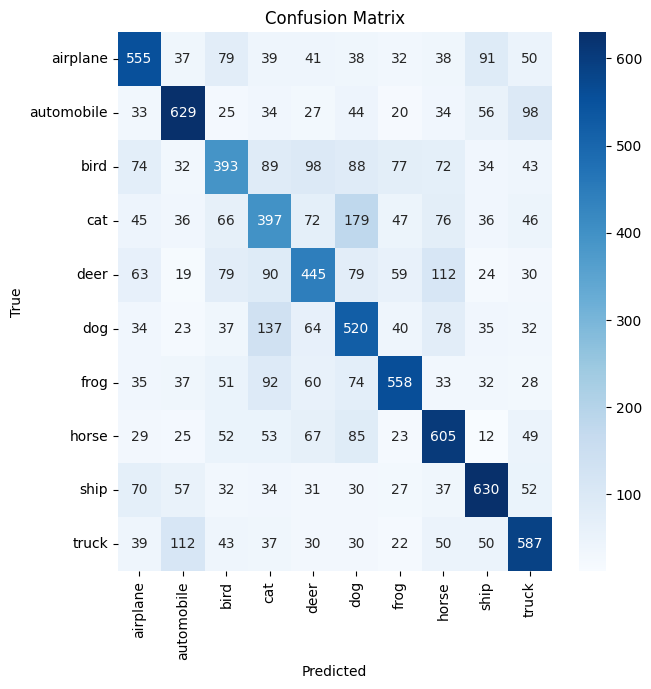

In [24]:
evaluate_model(model, testloader)

### DeeperCNN

In [25]:
# randomly shuffle 20% of the labels

trainset, trainloader, testloader = get_dataloaders(transform)

num_samples = len(trainset.targets)
num_noisy = int(0.2 * num_samples)

indices_to_corrupt = np.random.choice(num_samples, num_noisy, replace=False)
original_targets = torch.tensor(trainset.targets)
noisy_targets = original_targets.clone()

for idx in indices_to_corrupt:
    true_label = noisy_targets[idx].item()
    new_label = random.choice([l for l in range(10) if l != true_label])
    noisy_targets[idx] = new_label

trainset.targets = noisy_targets.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [26]:
model = DeeperCNN()
train_model(model, trainloader, epochs=75)

Epoch 1: Loss = 1.9100


Epoch 2: Loss = 1.7379


Epoch 3: Loss = 1.6381


Epoch 4: Loss = 1.5499


Epoch 5: Loss = 1.4690


Epoch 6: Loss = 1.3895


Epoch 7: Loss = 1.2872


Epoch 8: Loss = 1.1682


Epoch 9: Loss = 1.0296


Epoch 10: Loss = 0.8891


Epoch 11: Loss = 0.7623


Epoch 12: Loss = 0.6553


Epoch 13: Loss = 0.5765


Epoch 14: Loss = 0.5064


Epoch 15: Loss = 0.4526


Epoch 16: Loss = 0.4045


Epoch 17: Loss = 0.3675


Epoch 18: Loss = 0.3436


Epoch 19: Loss = 0.3215


Epoch 20: Loss = 0.2992


Epoch 21: Loss = 0.2682


Epoch 22: Loss = 0.2662


Epoch 23: Loss = 0.2378


Epoch 24: Loss = 0.2264


Epoch 25: Loss = 0.2191


Epoch 26: Loss = 0.2070


Epoch 27: Loss = 0.1960


Epoch 28: Loss = 0.1839


Epoch 29: Loss = 0.1747


Epoch 30: Loss = 0.1724


Epoch 31: Loss = 0.1656


Epoch 32: Loss = 0.1625


Epoch 33: Loss = 0.1512


Epoch 34: Loss = 0.1434


Epoch 35: Loss = 0.1437


Epoch 36: Loss = 0.1349


Epoch 37: Loss = 0.1306


Epoch 38: Loss = 0.1261


Epoch 39: Loss = 0.1253


Epoch 40: Loss = 0.1135


Epoch 41: Loss = 0.1100


Epoch 42: Loss = 0.1150


Epoch 43: Loss = 0.1138


Epoch 44: Loss = 0.1114


Epoch 45: Loss = 0.1013


Epoch 46: Loss = 0.0982


Epoch 47: Loss = 0.0978


Epoch 48: Loss = 0.0956


Epoch 49: Loss = 0.0938


Epoch 50: Loss = 0.0910


Epoch 51: Loss = 0.0860


Epoch 52: Loss = 0.0945


Epoch 53: Loss = 0.0792


Epoch 54: Loss = 0.0791


Epoch 55: Loss = 0.0799


Epoch 56: Loss = 0.0819


Epoch 57: Loss = 0.0750


Epoch 58: Loss = 0.0739


Epoch 59: Loss = 0.0712


Epoch 60: Loss = 0.0778


Epoch 61: Loss = 0.0669


Epoch 62: Loss = 0.0699


Epoch 63: Loss = 0.0673


Epoch 64: Loss = 0.0641


Epoch 65: Loss = 0.0640


Epoch 66: Loss = 0.0700


Epoch 67: Loss = 0.0642


Epoch 68: Loss = 0.0580


Epoch 69: Loss = 0.0590


Epoch 70: Loss = 0.0630


Epoch 71: Loss = 0.0599


Epoch 72: Loss = 0.0625


Epoch 73: Loss = 0.0582


Epoch 74: Loss = 0.0598


Epoch 75: Loss = 0.0530



Overall Test Accuracy: 60.52%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.60      0.66      0.63      1000
  automobile       0.71      0.76      0.73      1000
        bird       0.49      0.46      0.47      1000
         cat       0.46      0.36      0.40      1000
        deer       0.54      0.57      0.56      1000
         dog       0.53      0.57      0.55      1000
        frog       0.64      0.67      0.65      1000
       horse       0.69      0.59      0.64      1000
        ship       0.69      0.69      0.69      1000
       truck       0.67      0.71      0.69      1000

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.60      0.61      0.60     10000



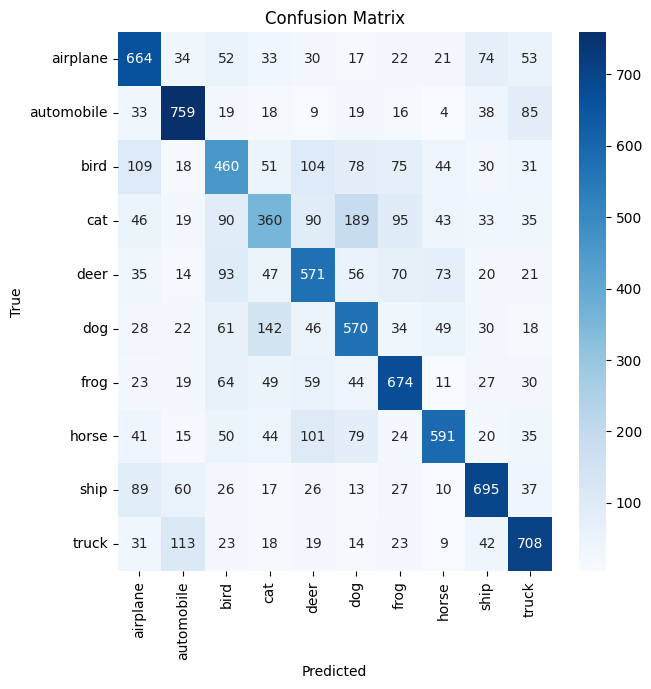

In [27]:
evaluate_model(model, testloader)

## input perturbation (crop)

In [28]:
# 같은 라벨을 사용하되 입력 이미지에 변화 주기: crop

### SimpleCNN

In [29]:
# crop out 28x28 patch out of 32x32 input

perturb_crop_transform = transforms.Compose([
    transforms.RandomCrop(28),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [30]:
# perturbation applied only to training data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=perturb_crop_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # clean
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
classes = trainset.classes  # global assignment (once)

In [31]:
model = SimpleCNN()
train_model(model, trainloader, epochs=50)

Epoch 1: Loss = 1.4223


Epoch 2: Loss = 1.0940


Epoch 3: Loss = 0.9471


Epoch 4: Loss = 0.8582


Epoch 5: Loss = 0.7787


Epoch 6: Loss = 0.7189


Epoch 7: Loss = 0.6724


Epoch 8: Loss = 0.6225


Epoch 9: Loss = 0.5813


Epoch 10: Loss = 0.5457


Epoch 11: Loss = 0.5165


Epoch 12: Loss = 0.4861


Epoch 13: Loss = 0.4598


Epoch 14: Loss = 0.4376


Epoch 15: Loss = 0.4117


Epoch 16: Loss = 0.3904


Epoch 17: Loss = 0.3779


Epoch 18: Loss = 0.3608


Epoch 19: Loss = 0.3412


Epoch 20: Loss = 0.3251


Epoch 21: Loss = 0.3112


Epoch 22: Loss = 0.3046


Epoch 23: Loss = 0.2931


Epoch 24: Loss = 0.2774


Epoch 25: Loss = 0.2685


Epoch 26: Loss = 0.2644


Epoch 27: Loss = 0.2497


Epoch 28: Loss = 0.2488


Epoch 29: Loss = 0.2346


Epoch 30: Loss = 0.2332


Epoch 31: Loss = 0.2260


Epoch 32: Loss = 0.2229


Epoch 33: Loss = 0.2137


Epoch 34: Loss = 0.2059


Epoch 35: Loss = 0.2025


Epoch 36: Loss = 0.1931


Epoch 37: Loss = 0.1995


Epoch 38: Loss = 0.1924


Epoch 39: Loss = 0.1884


Epoch 40: Loss = 0.1814


Epoch 41: Loss = 0.1776


Epoch 42: Loss = 0.1738


Epoch 43: Loss = 0.1697


Epoch 44: Loss = 0.1733


Epoch 45: Loss = 0.1624


Epoch 46: Loss = 0.1693


Epoch 47: Loss = 0.1631


Epoch 48: Loss = 0.1591


Epoch 49: Loss = 0.1482


Epoch 50: Loss = 0.1540



Overall Test Accuracy: 72.55%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.86      0.75      1000
  automobile       0.81      0.88      0.85      1000
        bird       0.77      0.54      0.63      1000
         cat       0.66      0.44      0.53      1000
        deer       0.73      0.61      0.66      1000
         dog       0.67      0.60      0.63      1000
        frog       0.62      0.90      0.74      1000
       horse       0.75      0.81      0.78      1000
        ship       0.86      0.78      0.82      1000
       truck       0.75      0.84      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000



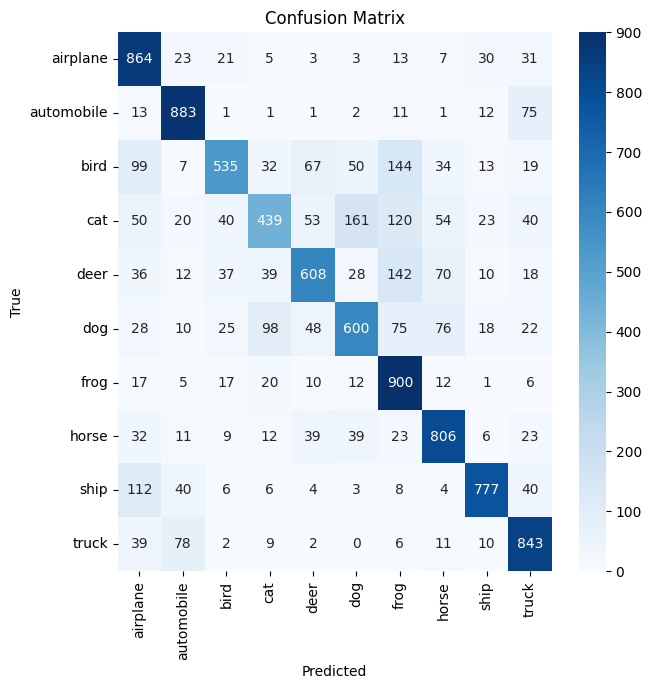

In [32]:
evaluate_model(model, testloader)

### DeeperCNN

In [33]:
# perturbation applied only to training data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=perturb_crop_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # clean
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [34]:
model = DeeperCNN()
train_model(model, trainloader, epochs=75)

Epoch 1: Loss = 1.4868


Epoch 2: Loss = 1.1445


Epoch 3: Loss = 0.9823


Epoch 4: Loss = 0.8765


Epoch 5: Loss = 0.8027


Epoch 6: Loss = 0.7399


Epoch 7: Loss = 0.6921


Epoch 8: Loss = 0.6431


Epoch 9: Loss = 0.6026


Epoch 10: Loss = 0.5692


Epoch 11: Loss = 0.5390


Epoch 12: Loss = 0.5113


Epoch 13: Loss = 0.4852


Epoch 14: Loss = 0.4691


Epoch 15: Loss = 0.4366


Epoch 16: Loss = 0.4206


Epoch 17: Loss = 0.3995


Epoch 18: Loss = 0.3866


Epoch 19: Loss = 0.3809


Epoch 20: Loss = 0.3623


Epoch 21: Loss = 0.3477


Epoch 22: Loss = 0.3312


Epoch 23: Loss = 0.3161


Epoch 24: Loss = 0.3089


Epoch 25: Loss = 0.2944


Epoch 26: Loss = 0.2858


Epoch 27: Loss = 0.2781


Epoch 28: Loss = 0.2744


Epoch 29: Loss = 0.2627


Epoch 30: Loss = 0.2553


Epoch 31: Loss = 0.2429


Epoch 32: Loss = 0.2403


Epoch 33: Loss = 0.2316


Epoch 34: Loss = 0.2298


Epoch 35: Loss = 0.2207


Epoch 36: Loss = 0.2132


Epoch 37: Loss = 0.2090


Epoch 38: Loss = 0.2046


Epoch 39: Loss = 0.2014


Epoch 40: Loss = 0.1981


Epoch 41: Loss = 0.1890


Epoch 42: Loss = 0.1849


Epoch 43: Loss = 0.1783


Epoch 44: Loss = 0.1804


Epoch 45: Loss = 0.1775


Epoch 46: Loss = 0.1715


Epoch 47: Loss = 0.1679


Epoch 48: Loss = 0.1613


Epoch 49: Loss = 0.1604


Epoch 50: Loss = 0.1592


Epoch 51: Loss = 0.1556


Epoch 52: Loss = 0.1540


Epoch 53: Loss = 0.1551


Epoch 54: Loss = 0.1474


Epoch 55: Loss = 0.1436


Epoch 56: Loss = 0.1413


Epoch 57: Loss = 0.1410


Epoch 58: Loss = 0.1356


Epoch 59: Loss = 0.1398


Epoch 60: Loss = 0.1361


Epoch 61: Loss = 0.1359


Epoch 62: Loss = 0.1301


Epoch 63: Loss = 0.1266


Epoch 64: Loss = 0.1242


Epoch 65: Loss = 0.1298


Epoch 66: Loss = 0.1243


Epoch 67: Loss = 0.1213


Epoch 68: Loss = 0.1217


Epoch 69: Loss = 0.1209


Epoch 70: Loss = 0.1134


Epoch 71: Loss = 0.1138


Epoch 72: Loss = 0.1156


Epoch 73: Loss = 0.1102


Epoch 74: Loss = 0.1115


Epoch 75: Loss = 0.1121



Overall Test Accuracy: 80.69%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.86      0.83      1000
  automobile       0.85      0.93      0.89      1000
        bird       0.70      0.77      0.73      1000
         cat       0.74      0.58      0.65      1000
        deer       0.78      0.75      0.77      1000
         dog       0.85      0.63      0.72      1000
        frog       0.75      0.92      0.82      1000
       horse       0.83      0.86      0.85      1000
        ship       0.90      0.89      0.89      1000
       truck       0.89      0.88      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



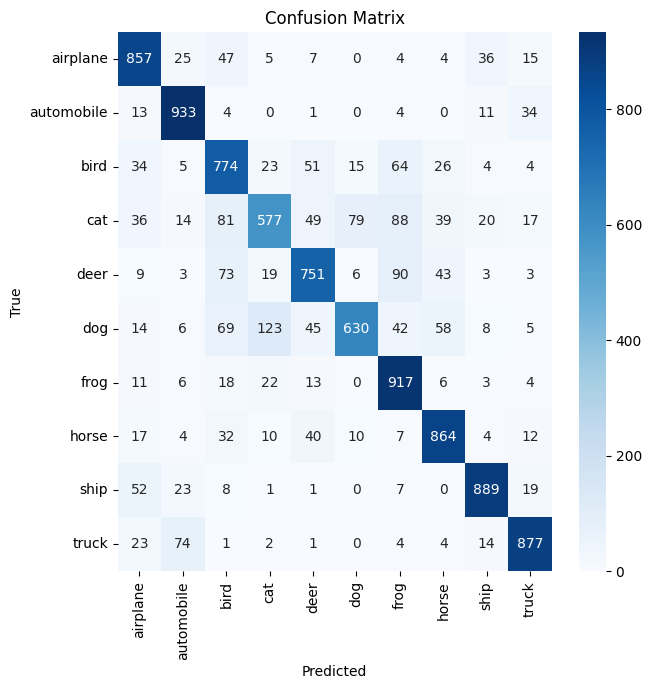

In [35]:
evaluate_model(model, testloader)

## input perturbation (blur)

In [36]:
# 같은 라벨을 사용하되 입력 이미지에 변화 주기: blur

### SimpleCNN

In [37]:
# apply low ~ moderate blur

perturb_blur_transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [38]:
# perturbation applied only to training data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=perturb_blur_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # clean
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
classes = trainset.classes  # global assignment (once)

In [39]:
model = SimpleCNN()
train_model(model, trainloader, epochs=50)

Epoch 1: Loss = 1.4372


Epoch 2: Loss = 1.1083


Epoch 3: Loss = 0.9547


Epoch 4: Loss = 0.8329


Epoch 5: Loss = 0.7227


Epoch 6: Loss = 0.6242


Epoch 7: Loss = 0.5266


Epoch 8: Loss = 0.4500


Epoch 9: Loss = 0.3649


Epoch 10: Loss = 0.3052


Epoch 11: Loss = 0.2513


Epoch 12: Loss = 0.2179


Epoch 13: Loss = 0.1760


Epoch 14: Loss = 0.1563


Epoch 15: Loss = 0.1377


Epoch 16: Loss = 0.1269


Epoch 17: Loss = 0.1176


Epoch 18: Loss = 0.1041


Epoch 19: Loss = 0.1010


Epoch 20: Loss = 0.0954


Epoch 21: Loss = 0.0841


Epoch 22: Loss = 0.0868


Epoch 23: Loss = 0.0816


Epoch 24: Loss = 0.0815


Epoch 25: Loss = 0.0737


Epoch 26: Loss = 0.0749


Epoch 27: Loss = 0.0728


Epoch 28: Loss = 0.0662


Epoch 29: Loss = 0.0656


Epoch 30: Loss = 0.0723


Epoch 31: Loss = 0.0635


Epoch 32: Loss = 0.0645


Epoch 33: Loss = 0.0575


Epoch 34: Loss = 0.0653


Epoch 35: Loss = 0.0615


Epoch 36: Loss = 0.0518


Epoch 37: Loss = 0.0524


Epoch 38: Loss = 0.0543


Epoch 39: Loss = 0.0599


Epoch 40: Loss = 0.0552


Epoch 41: Loss = 0.0561


Epoch 42: Loss = 0.0515


Epoch 43: Loss = 0.0495


Epoch 44: Loss = 0.0521


Epoch 45: Loss = 0.0560


Epoch 46: Loss = 0.0464


Epoch 47: Loss = 0.0485


Epoch 48: Loss = 0.0403


Epoch 49: Loss = 0.0501


Epoch 50: Loss = 0.0439



Overall Test Accuracy: 66.97%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.73      0.71      1000
  automobile       0.75      0.80      0.77      1000
        bird       0.59      0.56      0.57      1000
         cat       0.47      0.48      0.47      1000
        deer       0.64      0.60      0.62      1000
         dog       0.57      0.57      0.57      1000
        frog       0.72      0.78      0.75      1000
       horse       0.71      0.74      0.73      1000
        ship       0.77      0.76      0.77      1000
       truck       0.78      0.69      0.73      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



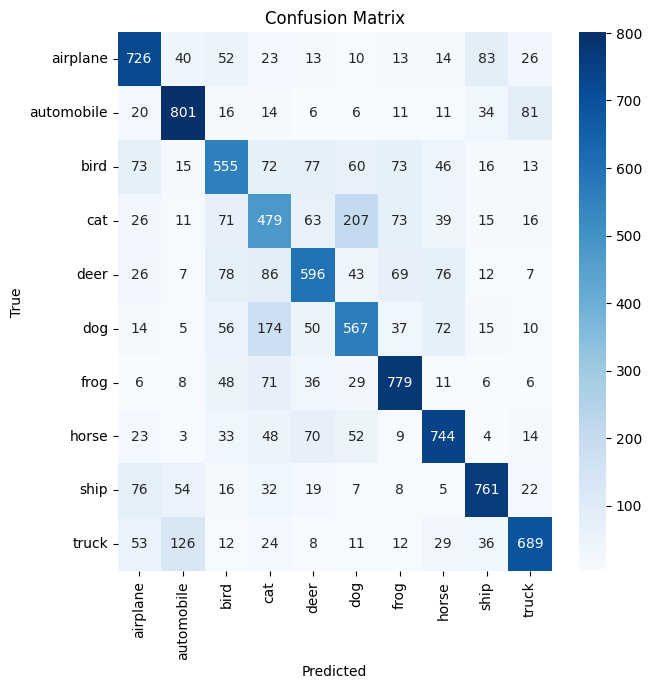

In [40]:
evaluate_model(model, testloader)

### DeeperCNN

In [41]:
# perturbation applied only to training data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=perturb_blur_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # clean
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [42]:
model = DeeperCNN()
train_model(model, trainloader, epochs=75)

Epoch 1: Loss = 1.5160


Epoch 2: Loss = 1.2168


Epoch 3: Loss = 1.0443


Epoch 4: Loss = 0.9235


Epoch 5: Loss = 0.8190


Epoch 6: Loss = 0.7331


Epoch 7: Loss = 0.6497


Epoch 8: Loss = 0.5753


Epoch 9: Loss = 0.5114


Epoch 10: Loss = 0.4453


Epoch 11: Loss = 0.3964


Epoch 12: Loss = 0.3453


Epoch 13: Loss = 0.3112


Epoch 14: Loss = 0.2706


Epoch 15: Loss = 0.2412


Epoch 16: Loss = 0.2183


Epoch 17: Loss = 0.2075


Epoch 18: Loss = 0.1835


Epoch 19: Loss = 0.1748


Epoch 20: Loss = 0.1570


Epoch 21: Loss = 0.1555


Epoch 22: Loss = 0.1446


Epoch 23: Loss = 0.1382


Epoch 24: Loss = 0.1299


Epoch 25: Loss = 0.1270


Epoch 26: Loss = 0.1205


Epoch 27: Loss = 0.1096


Epoch 28: Loss = 0.1107


Epoch 29: Loss = 0.1016


Epoch 30: Loss = 0.1022


Epoch 31: Loss = 0.0952


Epoch 32: Loss = 0.0978


Epoch 33: Loss = 0.0955


Epoch 34: Loss = 0.0875


Epoch 35: Loss = 0.0831


Epoch 36: Loss = 0.0897


Epoch 37: Loss = 0.0864


Epoch 38: Loss = 0.0807


Epoch 39: Loss = 0.0767


Epoch 40: Loss = 0.0726


Epoch 41: Loss = 0.0753


Epoch 42: Loss = 0.0765


Epoch 43: Loss = 0.0745


Epoch 44: Loss = 0.0692


Epoch 45: Loss = 0.0663


Epoch 46: Loss = 0.0735


Epoch 47: Loss = 0.0657


Epoch 48: Loss = 0.0631


Epoch 49: Loss = 0.0611


Epoch 50: Loss = 0.0585


Epoch 51: Loss = 0.0619


Epoch 52: Loss = 0.0596


Epoch 53: Loss = 0.0563


Epoch 54: Loss = 0.0564


Epoch 55: Loss = 0.0554


Epoch 56: Loss = 0.0591


Epoch 57: Loss = 0.0537


Epoch 58: Loss = 0.0563


Epoch 59: Loss = 0.0555


Epoch 60: Loss = 0.0524


Epoch 61: Loss = 0.0537


Epoch 62: Loss = 0.0540


Epoch 63: Loss = 0.0514


Epoch 64: Loss = 0.0499


Epoch 65: Loss = 0.0476


Epoch 66: Loss = 0.0481


Epoch 67: Loss = 0.0433


Epoch 68: Loss = 0.0478


Epoch 69: Loss = 0.0455


Epoch 70: Loss = 0.0496


Epoch 71: Loss = 0.0472


Epoch 72: Loss = 0.0410


Epoch 73: Loss = 0.0469


Epoch 74: Loss = 0.0428


Epoch 75: Loss = 0.0431



Overall Test Accuracy: 74.43%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.79      0.78      1000
  automobile       0.84      0.88      0.86      1000
        bird       0.63      0.66      0.65      1000
         cat       0.58      0.57      0.57      1000
        deer       0.73      0.65      0.69      1000
         dog       0.64      0.64      0.64      1000
        frog       0.79      0.77      0.78      1000
       horse       0.76      0.81      0.78      1000
        ship       0.83      0.88      0.85      1000
       truck       0.85      0.81      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



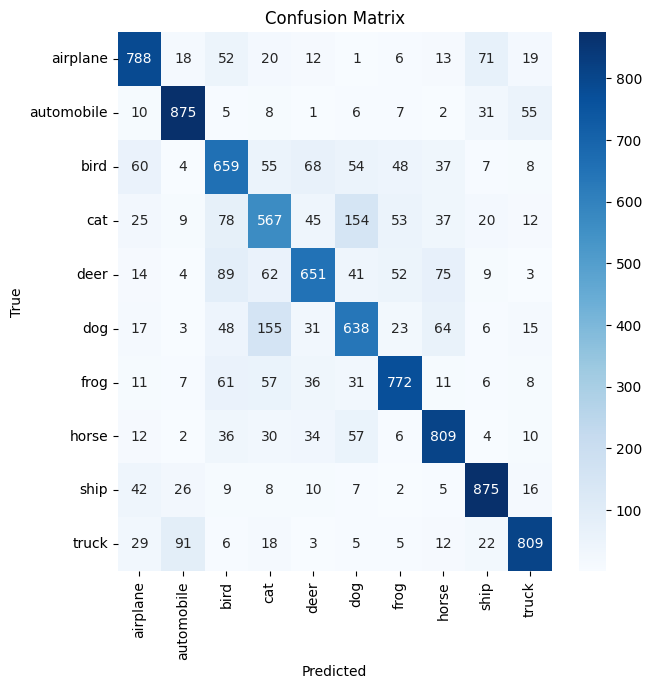

In [43]:
evaluate_model(model, testloader)

In [44]:
""" end of notebook """

' end of notebook '